In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import os
from google.colab import files

# Upload kaggle.json file
print("Please upload your kaggle.json file.")
# This will open a file selection dialog in the Colab environment
uploaded = files.upload()

if 'kaggle.json' in uploaded:
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("Kaggle API key uploaded and configured securely.")
else:
    print("Kaggle API key not uploaded. Dataset download may fail.")

Please upload your kaggle.json file.


Saving kaggle.json to kaggle.json
Kaggle API key uploaded and configured securely.


In [ ]:
!kaggle datasets download -d raghadalharbi/breast-cancer-gene-expression-profiles-metabric
!unzip -o breast-cancer-gene-expression-profiles-metabric.zip

Dataset URL: https://www.kaggle.com/datasets/raghadalharbi/breast-cancer-gene-expression-profiles-metabric
License(s): DbCL-1.0
  0% 0.00/2.72M [00:00<?, ?B/s]
100% 2.72M/2.72M [00:00<00:00, 755MB/s]
Archive:  breast-cancer-gene-expression-profiles-metabric.zip
  inflating: METABRIC_RNA_Mutation.csv  


In [ ]:
df = pd.read_csv("METABRIC_RNA_Mutation.csv")

print("Shape:", df.shape)
df.head()

Shape: (1904, 693)


,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df = df.drop(columns=["patient_id"], errors="ignore")

target_col = "pam50_+_claudin-low_subtype"
df[target_col].value_counts()

,count
pam50_+_claudin-low_subtype,
LumA,679
LumB,461
Her2,220
claudin-low,199
Basal,199
Normal,140
NC,6


In [ ]:
# Numeric → median
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Categorical → mode
cat_cols = df.select_dtypes(include=["object"]).columns
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

In [ ]:
le = LabelEncoder()
df[target_col] = le.fit_transform(df[target_col])

# One-hot encode other categorical columns
df = pd.get_dummies(df, drop_first=True)

print("New shape:", df.shape)

New shape: (1904, 8309)


In [ ]:
X = df.drop(columns=[target_col])
y = df[target_col]

In [ ]:
X_train_raw, X_test_raw, y_train_original, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_raw.shape, X_test_raw.shape

((1523, 8308), (381, 8308))

In [ ]:
# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
# Transform the test data using the scaler fitted on the training data
X_test_scaled = scaler.transform(X_test_raw)

# Apply SMOTE to fix imbalance
sm = SMOTE(random_state=42, k_neighbors=3)
X_train_resampled, y_train = sm.fit_resample(X_train_scaled, y_train_original)

# PCA: Keep 200 components (more components for better learning)
pca = PCA(n_components=200)
X_train = pca.fit_transform(X_train_resampled)
X_test = pca.transform(X_test_scaled)

print(f"Original Split (Raw): {X_train_raw.shape}, {X_test_raw.shape}")
print(f"SMOTE-PCA Transformed (Train): {X_train.shape}, {y_train.shape}")
print(f"PCA Transformed (Test): {X_test.shape}, {y_test.shape}")

Original Split (Raw): (1523, 8308), (381, 8308)
SMOTE-PCA Transformed (Train): (3801, 200), (3801,)
PCA Transformed (Test): (381, 200), (381,)


In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, class_weight="balanced"),
    "SVM (RBF)": SVC(kernel="rbf", probability=True, class_weight="balanced"),
    "Neural Network (MLP)": MLPClassifier(hidden_layer_sizes=(128,64), max_iter=500),
    "Random Forest": RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_split=2,
        class_weight="balanced_subsample",
        random_state=42
    ),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(
        n_estimators=500,
        max_depth=7,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        objective="multi:softprob",
        num_class=len(np.unique(y)),
        eval_metric="mlogloss",
        tree_method="hist"
    )
}
trained_models = {}

for name, model in models.items():
    print(f"Training: {name}")
    model.fit(X_train, y_train)
    trained_models[name] = model


Training: Logistic Regression
Training: SVM (RBF)
Training: Neural Network (MLP)
Training: Random Forest
Training: Naive Bayes
Training: XGBoost


In [ ]:
def evaluate(model, name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="macro")
    rec  = recall_score(y_test, y_pred, average="macro")
    f1   = f1_score(y_test, y_pred, average="macro")
    auc  = roc_auc_score(y_test, y_prob, multi_class="ovr")

    print(f"\n📌 Results for {name}")
    print("----------------------------------")
    print("Accuracy :", acc)
    print("Precision:", prec)
    print("Recall   :", rec)
    print("F1 Score :", f1)
    print("ROC-AUC  :", auc)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return acc, prec, rec, f1, auc

In [ ]:
results = {}

for name, model in trained_models.items():
    results[name] = evaluate(model, name)


📌 Results for Logistic Regression
----------------------------------
Accuracy : 0.7690288713910761
Precision: 0.6510816653414689
Recall   : 0.6499481610826149
F1 Score : 0.649376888575001
ROC-AUC  : 0.9089062995339734

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85        40
           1       0.66      0.66      0.66        44
           2       0.81      0.79      0.80       136
           3       0.73      0.75      0.74        92
           4       0.00      0.00      0.00         1
           5       0.70      0.57      0.63        28
           6       0.84      0.90      0.87        40

    accuracy                           0.77       381
   macro avg       0.65      0.65      0.65       381
weighted avg       0.77      0.77      0.77       381


📌 Results for SVM (RBF)
----------------------------------
Accuracy : 0.7769028871391076
Precision: 0.6751331839656078
Recall   : 0.6396132365989874
F1 Score :

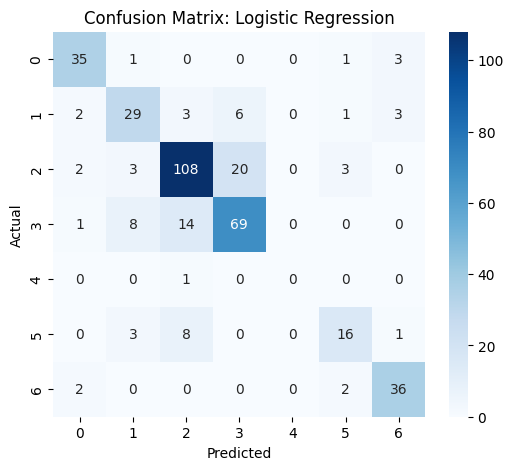

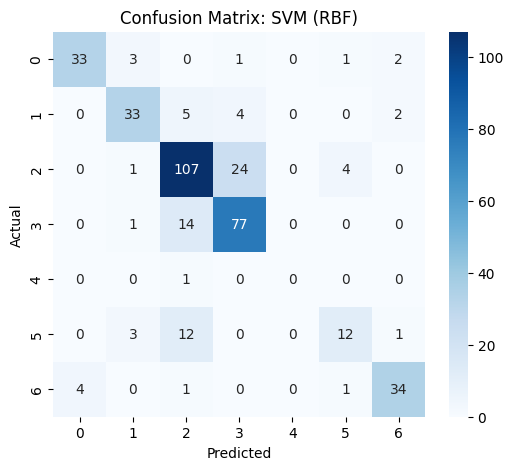

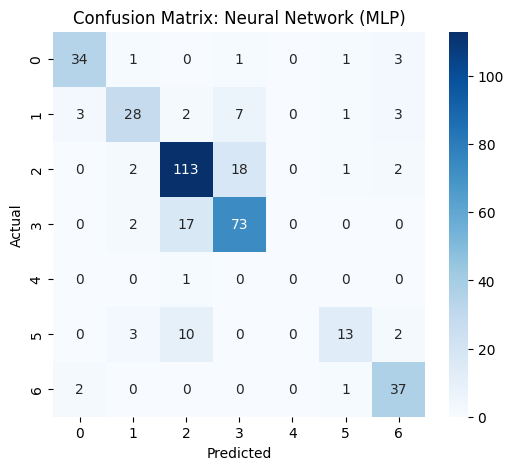

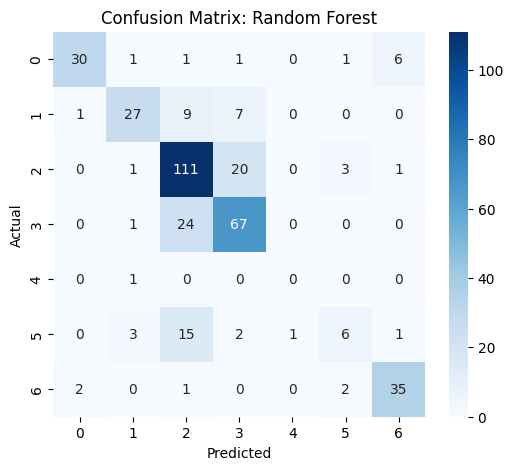

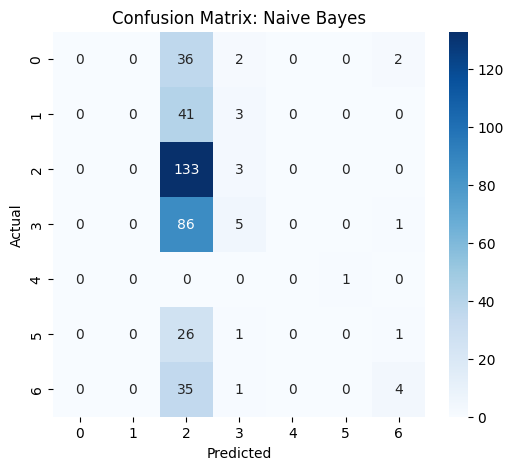

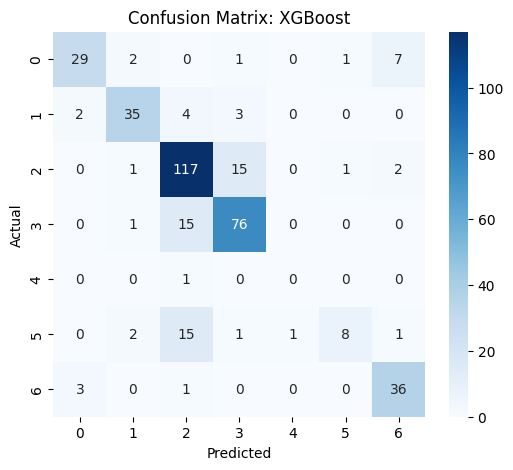

In [ ]:
def plot_cm(model, title):
  cm = confusion_matrix(y_test, model.predict(X_test))
  plt.figure(figsize=(6,5))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
  plt.title(title)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.show()

for name, model in trained_models.items():
  plot_cm(model, f"Confusion Matrix: {name}")

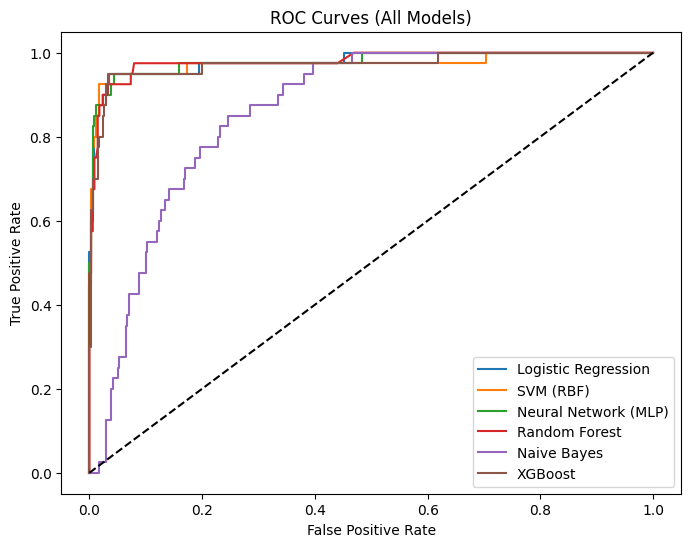

In [ ]:
plt.figure(figsize=(8,6))

for name, model in trained_models.items():
    y_prob = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob[:,0], pos_label=0)
    plt.plot(fpr, tpr, label=name)

plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curves (All Models)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [ ]:
results_df = pd.DataFrame(results, index=["Accuracy","Precision","Recall","F1","ROC-AUC"]).T
results_df

,Accuracy,Precision,Recall,F1,ROC-AUC
Logistic Regression,0.769029,0.651082,0.649948,0.649377,0.908906
SVM (RBF),0.776903,0.675133,0.639613,0.652750,0.925527
Neural Network (MLP),0.782152,0.675585,0.642859,0.651935,0.952391
Random Forest,0.724409,0.628189,0.571051,0.587724,0.882250
Naive Bayes,0.372703,0.172269,0.161756,0.114240,0.708766
XGBoost,0.790026,0.692226,0.627507,0.640539,0.935665


In [ ]:
tuned_models = {}

# -------------------------------
# 1. SVM (RBF Kernel) Tuning
# -------------------------------
svm_param_grid = {
    "C": [0.1, 1, 10],
    "gamma": ["scale", "auto"],
    "kernel": ["rbf"]
}

svm_grid = GridSearchCV(
    SVC(probability=True, class_weight="balanced"),
    svm_param_grid,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1
)

svm_grid.fit(X_train, y_train)
best_svm = svm_grid.best_estimator_
tuned_models["SVM (Tuned)"] = best_svm
results["SVM (Tuned)"] = evaluate(best_svm, "SVM (Tuned)")
print("Best SVM params:", svm_grid.best_params_)


# -------------------------------
# 2. MLP Neural Network Tuning
# -------------------------------
mlp_param_grid = {
    "hidden_layer_sizes": [(64,), (128,), (128,64)],
    "activation": ["relu", "tanh"],
    "solver": ["adam"],
    "max_iter": [300]
}

mlp_grid = GridSearchCV(
    MLPClassifier(),
    mlp_param_grid,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1
)

mlp_grid.fit(X_train, y_train)
best_mlp = mlp_grid.best_estimator_
tuned_models["MLP (Tuned)"] = best_mlp
results["MLP (Tuned)"] = evaluate(best_mlp, "MLP (Tuned)")
print("Best MLP params:", mlp_grid.best_params_)


# -------------------------------
# 3. Random Forest Tuning
# -------------------------------
rf_param_grid = {
    "n_estimators": [200, 400, 600],
    "max_depth": [5, 7, 9],
    "min_samples_split": [2, 5]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(class_weight="balanced_subsample", random_state=42),
    rf_param_grid,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_
tuned_models["Random Forest (Tuned)"] = best_rf
results["Random Forest (Tuned)"] = evaluate(best_rf, "Random Forest (Tuned)")
print("Best RF params:", rf_grid.best_params_)


# -------------------------------
# 4. XGBoost Tuning
# -------------------------------
xgb_param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [5, 7],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
}

xgb_grid = GridSearchCV(
    XGBClassifier(
        objective="multi:softprob",
        num_class=len(np.unique(y)),
        eval_metric="mlogloss",
        tree_method="hist"
    ),
    xgb_param_grid,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1
)

xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_
tuned_models["XGBoost (Tuned)"] = best_xgb
results["XGBoost (Tuned)"] = evaluate(best_xgb, "XGBoost (Tuned)")
print("Best XGBoost params:", xgb_grid.best_params_)



📌 Results for SVM (Tuned)
----------------------------------
Accuracy : 0.7979002624671916
Precision: 0.7196722137733943
Recall   : 0.6525562398872592
F1 Score : 0.6691050429243823
ROC-AUC  : 0.9136571257937139

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.82      0.84        40
           1       0.80      0.75      0.78        44
           2       0.79      0.84      0.81       136
           3       0.74      0.83      0.78        92
           4       0.00      0.00      0.00         1
           5       1.00      0.43      0.60        28
           6       0.86      0.90      0.88        40

    accuracy                           0.80       381
   macro avg       0.72      0.65      0.67       381
weighted avg       0.81      0.80      0.79       381

Best SVM params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

📌 Results for MLP (Tuned)
----------------------------------
Accuracy : 0.800524934383202
Precision: 0.6

In [ ]:
soft_ensemble = VotingClassifier(
    estimators=[
        ("svm", trained_models["SVM (RBF)"]),
        ("mlp", trained_models["Neural Network (MLP)"]),
        ("rf", trained_models["Random Forest"]),
        ("xgb", trained_models["XGBoost"])
    ],
    voting="soft"
)

soft_ensemble.fit(X_train, y_train)

# Evaluate soft ensemble
results["Soft Voting Ensemble"] = evaluate(soft_ensemble, "Soft Voting Ensemble")
trained_models["Soft Voting Ensemble"] = soft_ensemble


📌 Results for Soft Voting Ensemble
----------------------------------
Accuracy : 0.8162729658792651
Precision: 0.7254202784866706
Recall   : 0.6600868806020432
F1 Score : 0.6809122403737212
ROC-AUC  : 0.9214097283624866

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.80      0.86        40
           1       0.85      0.77      0.81        44
           2       0.79      0.88      0.84       136
           3       0.78      0.84      0.81        92
           4       0.00      0.00      0.00         1
           5       0.86      0.43      0.57        28
           6       0.86      0.90      0.88        40

    accuracy                           0.82       381
   macro avg       0.73      0.66      0.68       381
weighted avg       0.82      0.82      0.81       381



In [ ]:
stacked = StackingClassifier(
    estimators=[
        ("svm", trained_models["SVM (RBF)"]),
        ("mlp", trained_models["Neural Network (MLP)"]),
        ("rf", trained_models["Random Forest"]),
        ("xgb", trained_models["XGBoost"])
    ],
    final_estimator=LogisticRegression(max_iter=500)
)

stacked.fit(X_train, y_train)

results["Stacked Ensemble"] = evaluate(stacked, "Stacked Ensemble")
trained_models["Stacked Ensemble"] = stacked



📌 Results for Stacked Ensemble
----------------------------------
Accuracy : 0.7952755905511811
Precision: 0.7114951651717524
Recall   : 0.6476011748572947
F1 Score : 0.6620278843963054
ROC-AUC  : 0.9513159245432127

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87        40
           1       0.86      0.70      0.78        44
           2       0.77      0.85      0.81       136
           3       0.77      0.82      0.79        92
           4       0.00      0.00      0.00         1
           5       0.92      0.39      0.55        28
           6       0.77      0.93      0.84        40

    accuracy                           0.80       381
   macro avg       0.71      0.65      0.66       381
weighted avg       0.80      0.80      0.79       381



In [ ]:
# LIME for model explanations
!pip install LIME
from lime import lime_tabular

# Create PCA component names
pca_feature_names = [f"PC{i+1}" for i in range(X_train.shape[1])]

explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=pca_feature_names,
    class_names=le.classes_.tolist(),
    mode="classification"
)

exp = explainer.explain_instance(
    X_test[0],
    best_rf.predict_proba,
    num_features=10,
    top_labels=1
)

exp.show_in_notebook(show_table=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for LIME: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=d6788d3ee5d15659ce53df223ab02ee1e39bbf892e9c85c8fc1a847e91e59187
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built LIME


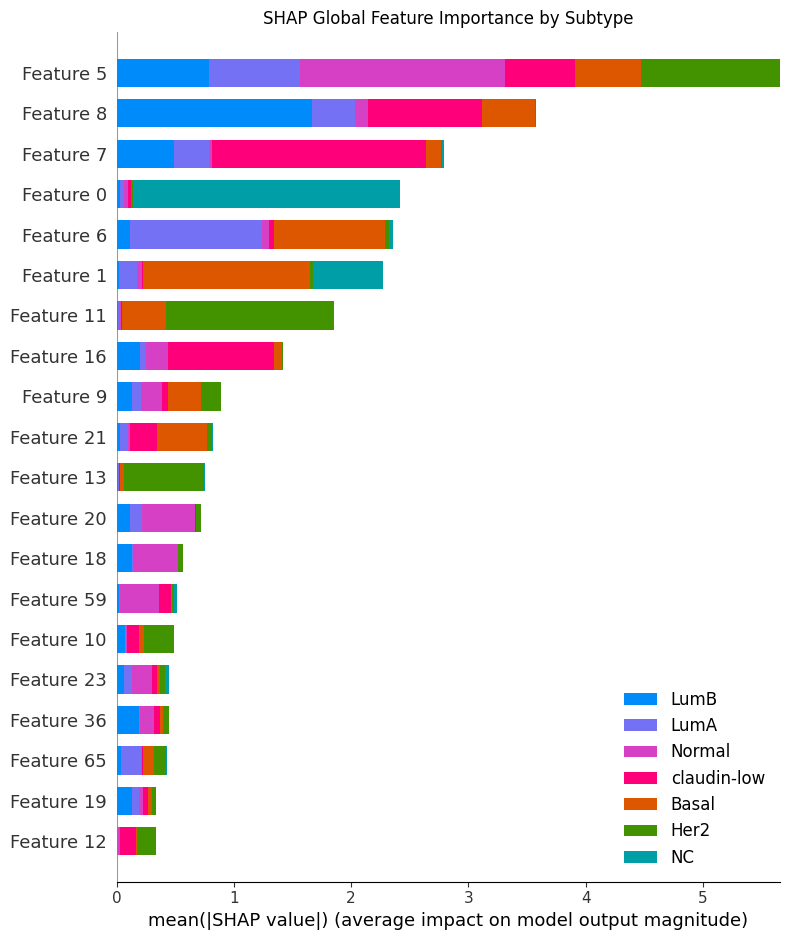

In [ ]:
#Untuned XGboost SHAP explanations
import shap
shap.initjs()

model = trained_models["XGBoost"]
explainer_shap = shap.TreeExplainer(model)
shap_values = explainer_shap.shap_values(X_test)

class_names = le.classes_.tolist()

# Summary plot
shap.summary_plot(
    shap_values,
    X_test,
    plot_type="bar",
    class_names=class_names,
    show=False
)
plt.title("SHAP Global Feature Importance by Subtype")
plt.tight_layout()
plt.show()

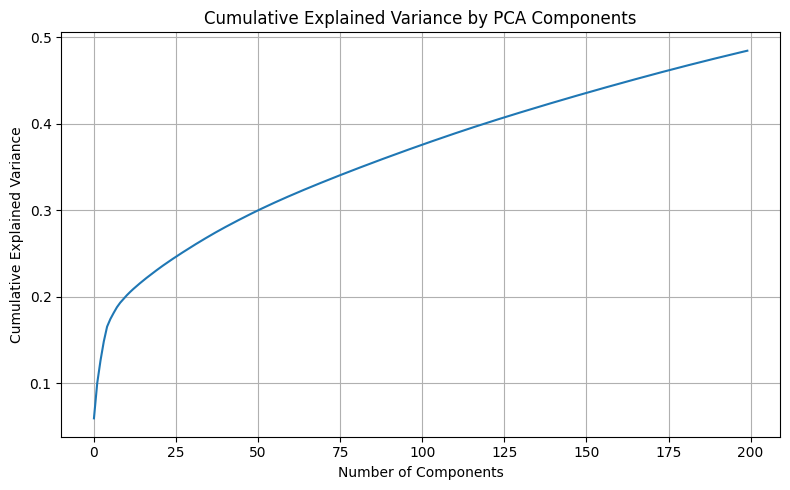

In [ ]:
# Explained variance ratio
variance = pca.explained_variance_ratio_
cumulative = np.cumsum(variance)

plt.figure(figsize=(8,5))
plt.plot(cumulative)
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.tight_layout()

plt.savefig("pca_variance_placeholder.png", dpi=300)
plt.show()

<Figure size 800x500 with 0 Axes>

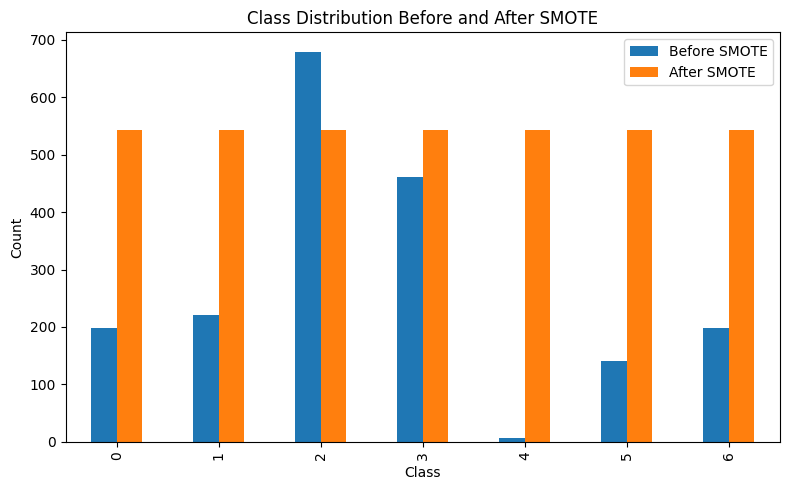

In [ ]:
# Before SMOTE distribution
before_counts = pd.Series(y).value_counts().sort_index()

# After SMOTE distribution
after_counts = pd.Series(y_train).value_counts().sort_index()

plt.figure(figsize=(8,5))

df_plot = pd.DataFrame({
    "Before SMOTE": before_counts,
    "After SMOTE": after_counts
})

df_plot.plot(kind="bar", figsize=(8,5))
plt.title("Class Distribution Before and After SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()

plt.savefig("smote_distribution_placeholder.png", dpi=300)
plt.show()

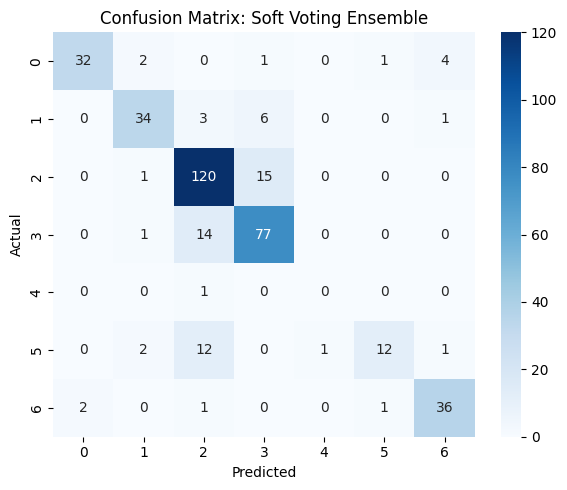

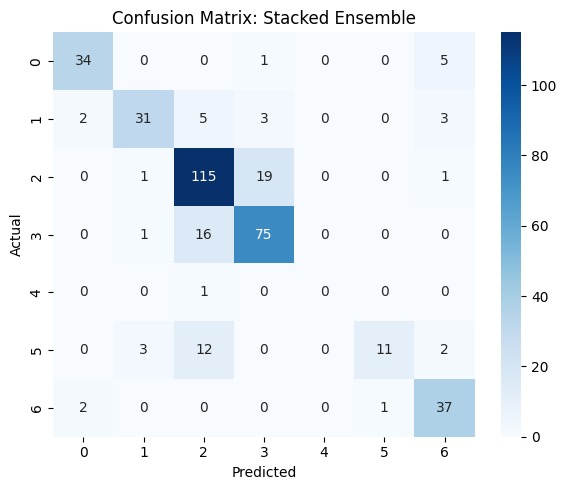

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def save_conf_matrix(model, title, filename):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()


# 1. Soft Voting Ensemble
save_conf_matrix(
    soft_ensemble,
    "Confusion Matrix: Soft Voting Ensemble",
    "cm_soft_voting.png"
)

# 2. Stacked Ensemble
save_conf_matrix(
    stacked,
    "Confusion Matrix: Stacked Ensemble",
    "cm_stacked.png"
)

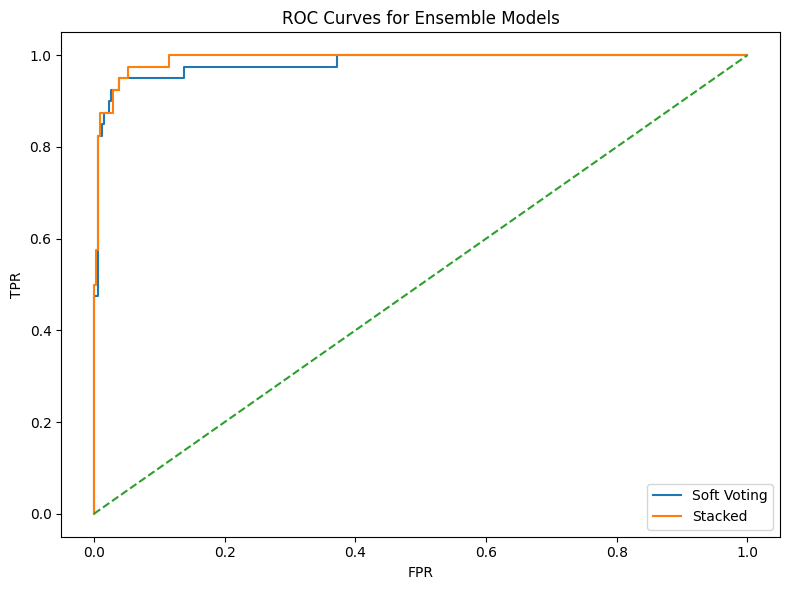

In [ ]:
plt.figure(figsize=(8,6))

for name, model in [
    ("Soft Voting", soft_ensemble),
    ("Stacked", stacked)
]:
    y_prob = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob[:,0], pos_label=0)
    plt.plot(fpr, tpr, label=name)

plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curves for Ensemble Models")
plt.legend()
plt.tight_layout()
plt.savefig("roc_ensemble.png", dpi=300)
plt.show()

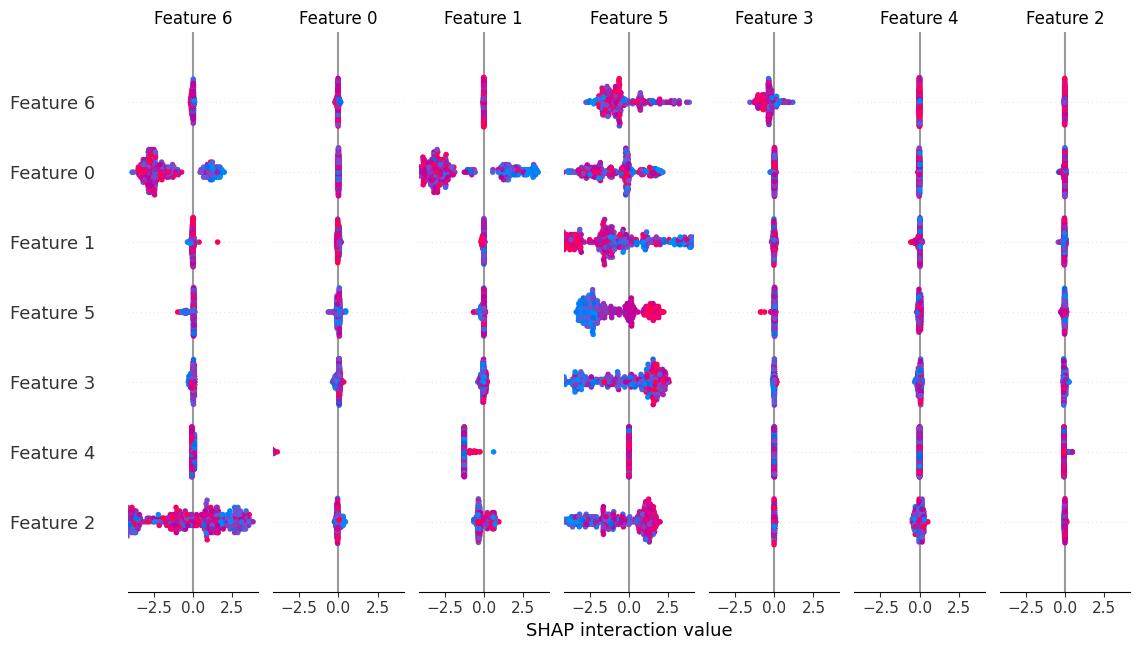

In [ ]:
#SHAP explainer for the tuned XGBoost model
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, show=False)
plt.tight_layout()
plt.savefig("tuned_shap_summary.png", dpi=300)
plt.show()

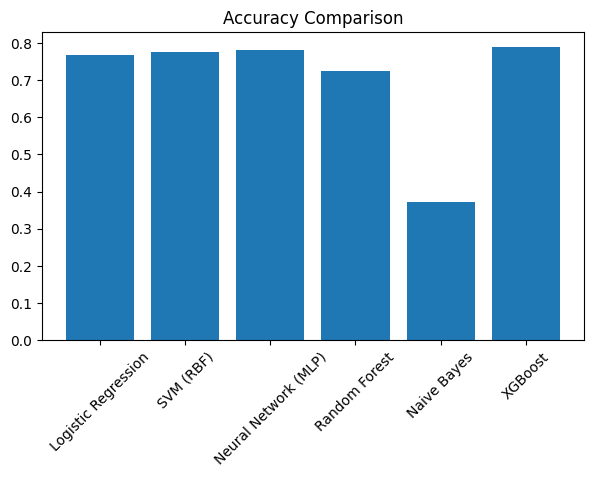

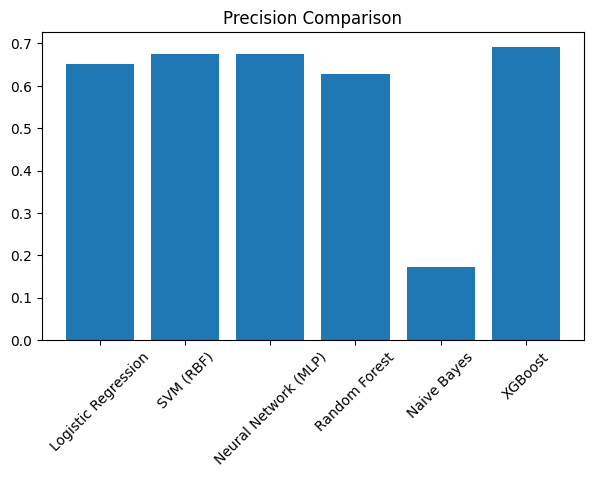

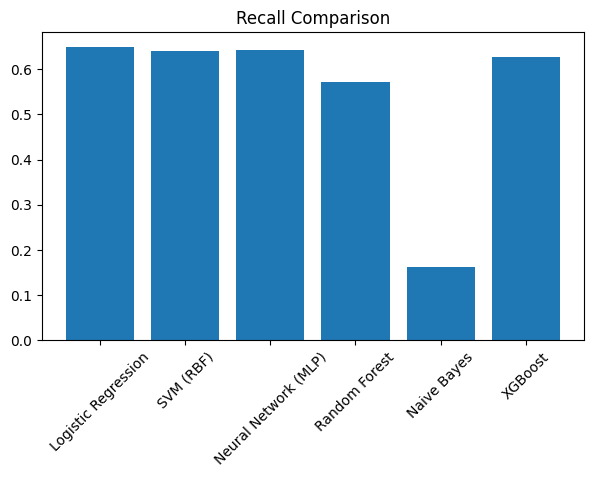

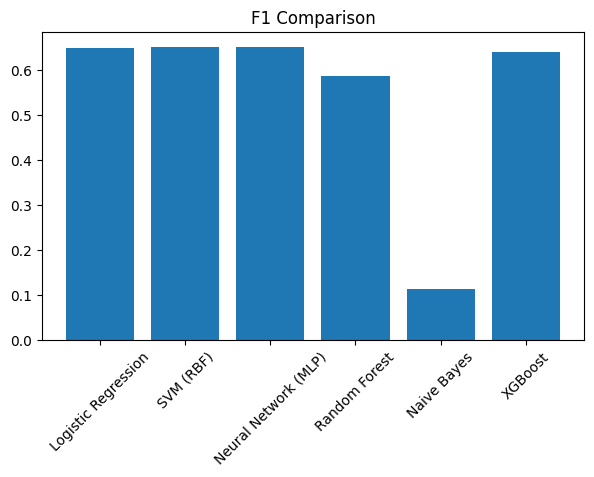

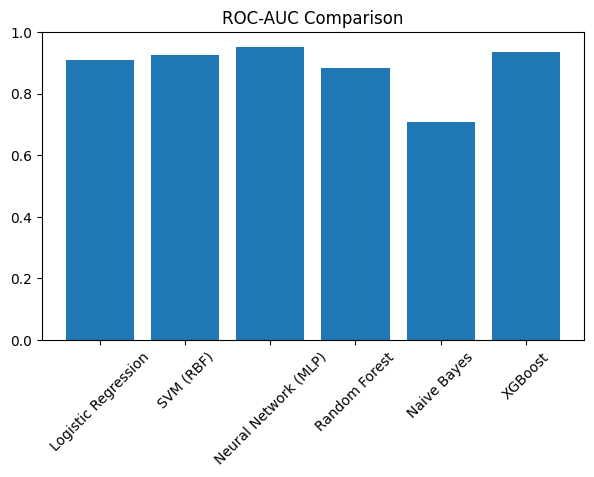

In [ ]:
metrics = ["Accuracy","Precision","Recall","F1","ROC-AUC"]

for metric_index, metric_name in enumerate(metrics):
    plt.figure(figsize=(7,4))
    values = [results_df.loc[m, metric_name] for m in results_df.index]
    plt.bar(results_df.index, values)
    plt.title(f"{metric_name} Comparison")
    plt.xticks(rotation=45)
    plt.show()